# 暗闇での物体検知・識別
## 目的
画像解析や物体検知技術は自動車などで今後も広がっていく技術である。しかし、雨天時や暗闇、明度に差のあるシチュエーションではセンサーや認識が誤作動を起こすことがある。
ここでは、暗闇で撮影された画像、もしくは、暗闇での写真となるように画像にノイズ加工を行ったデータに対して、CNNが正しく物体検出ができることを実現することを目指す。

## 対象
様々なシチュエーションの中で、ここでは暗闇での撮影を前提に処理を考える。

## 参考論文・文献
ディープラーニングを用いて暗闇の中で「見えない」オブジェクトを明らかにする（2019年 1月31日）https://ai-scholar.tech/articles/machine-learning/ai-dark-69
### Qiita
https://qiita.com/TrashBoxx/items/2d441e46643f73c0ca19


## 実装の方針


1.   Cifar10と以下に記述するCBIU2019を対象に分析を行う。
2.   Cifar10とCBIUに共通するカテゴリである、[cat, dog, Car(=automobile), Ship(=Boat)]を対象とし、後者のCarとShipに関しては精度が落ちる可能性があるため別途検証する。
3.   暗闇での物体検知のため、以下の3パターンを中心に実験する。
      * Cifar10事前学習済みモデル単体による検知
      * Cifar10の学習済みモデルに対しCBIUによるファインチューニングを施したパターン
      * CBIU単体のResNetによる学習をしたパターン
      上記3パターンを試み、結果を比較する。








In [1]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Mounted at /content/drive


In [2]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール

    !pip install torch==1.13.0 torchvision==0.14.0 torchvision torchcam grad-cam
else:
    print("Not Google Colab")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of torchcam to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39589 sha256=ac94e0b944e2689ebcfbf24f1cfad208515ff424c2378c6ebc37d657f9801122
  Stored

In [3]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, wide_resnet50_2
import os
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

import torchcam
import torchvision
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchcam.methods import CAM
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm

np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)
    torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### データセットの準備

データセットには、cifar10 とCBIU2019 を使用します。

cifar10 は10種類のクラスを含まれており、  
学習データ 50000枚、テストデータ 10000枚で構成されています。

データは 3チャンネル(RGB)の縦横 32×32 の配列`(3, 32, 32)`となっています。


### CBIU2019について
このデータセットは低照度環境下での物体検出の研究のためのデータセットです。

URL：http://cs-chan.com/doc/cviu.pdf

GitHub：https://github.com/cs-chan/Exclusively-Dark-Image-Dataset

7367枚の画像と 12個のオブジェクトクラスを用意している。


Cloning into 'kaggle_dataset_downloader'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 5), reused 8 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 4.32 KiB | 4.32 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Donwloading: mangosata/exclusivelydarkimagedataset-from-cschan
Donwload Completed: mangosata/exclusivelydarkimagedataset-from-cschan


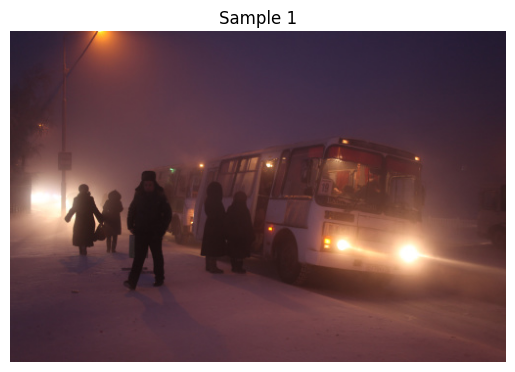

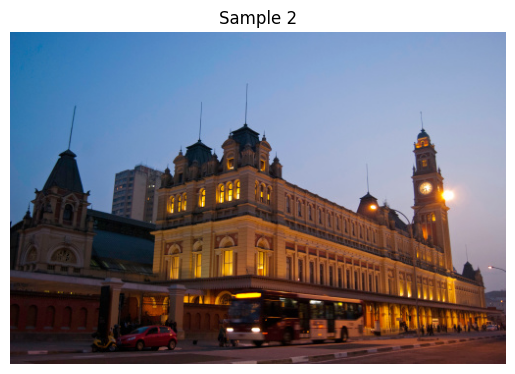

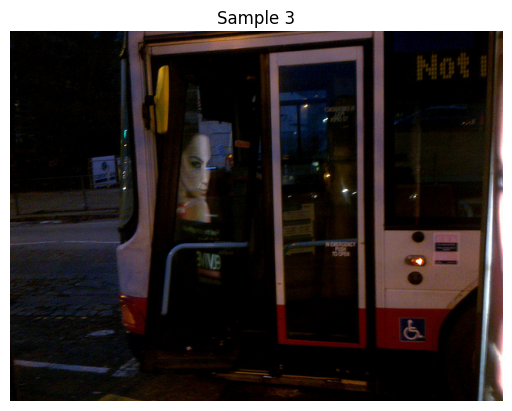

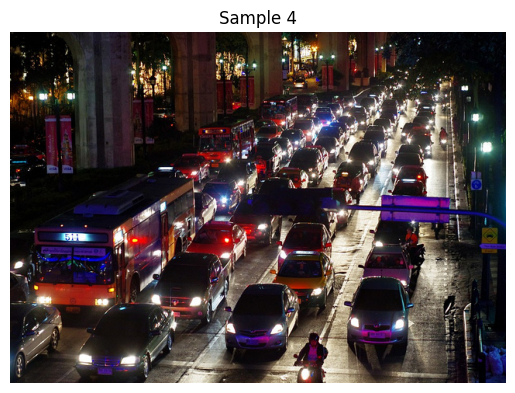

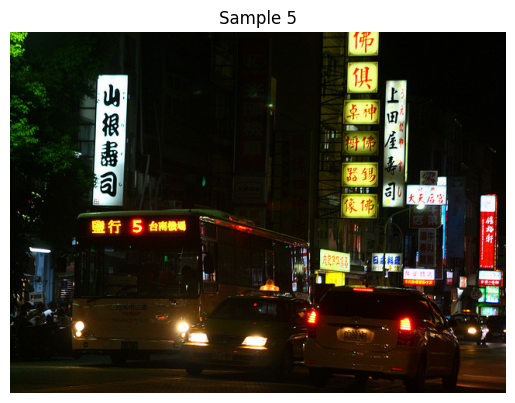

In [4]:
#kaggleから画像データセットを取得し、サンプルで確認する

dataset_name = "mangosata/exclusivelydarkimagedataset-from-cschan"

!pip install -q kaggle
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/colab/kaggle.json /root/.kaggle/

!git clone https://github.com/tttza/kaggle_dataset_downloader.git
from kaggle_dataset_downloader import download_dataset
download_dataset.get_dataset(dataset_name)


# ZIPファイルのパス
zip_file_path = "/content/download/exclusivelydarkimagedataset-from-cschan/exclusivelydarkimagedataset-from-cschan.zip"

# ZIPファイルを解凍
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dark_images")

# 解凍されたデータセットのディレクトリを指定
dataset_path = "/content/dark_images"

# ディレクトリ内の画像ファイルのリストを取得
image_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg')):
            image_files.append(os.path.join(root, file))

# サンプル画像を表示
num_samples = 5  # 表示するサンプル画像の数
for i in range(min(num_samples, len(image_files))):
    img = Image.open(image_files[i])
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Sample {i+1}')
    plt.show()


Cifar10データセットの準備

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


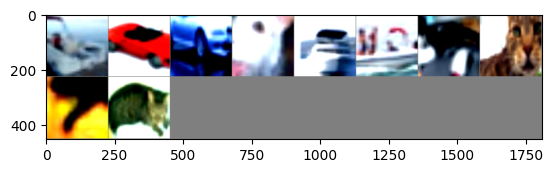

ship car car dog ship ship cat cat cat cat


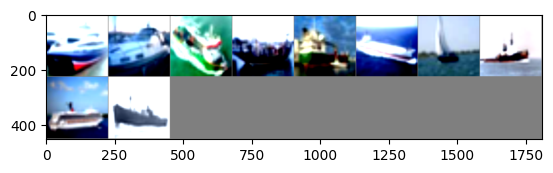

ship ship ship ship ship ship ship ship ship ship


In [5]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# Cifer10のデータの前処理

# 画像データを標準化する際の平均と分散、およびバッチサイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 10

# 学習データに適用する前処理
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),   # 短い辺の長さがresizeの大きさになる
    transforms.RandomHorizontalFlip(),          # ランダムに左右に反転する
    transforms.ToTensor(),                      # Torchテンソルに変換
    transforms.Normalize(mean, std)             # 色情報の標準化
])
trainset10 = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=train_transform
)

num_data =1000
num_classes = 4
# 船: 8, 自動車: 1, 犬: 5, 猫: 3 のインデックス
idx_list = [8, 1, 5, 3]

# 学習データから指定カテゴリの画像を抽出
mini_data = [[] for x in range(num_classes)]
for img, tgt in zip(trainset10.data, trainset10.targets):
    if tgt in idx_list:
        class_index = idx_list.index(tgt)
        if len(mini_data[class_index]) < num_data:
            mini_data[class_index].append(img)
mini_data = np.array(mini_data, dtype=trainset10.data.dtype).reshape(-1, 32, 32, 3)

# 学習データ用の正解ラベルを作成
mini_targets = []
for i in range(num_classes):
    tgt = [i] * num_data
    mini_targets += tgt

# 学習データの置き換え
trainset10.data = mini_data
trainset10.targets = mini_targets

# 学習データのデータローダ
trainloader10 = torch.utils.data.DataLoader(
    trainset10, batch_size=batch_size,
    shuffle=True, num_workers=2
)

# テストデータに適用する前処理
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # 短い辺の長さがresizeの大きさになる
    transforms.ToTensor(),              # Torchテンソルに変換
    transforms.Normalize(mean, std)     # 色情報の標準化
])
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=test_transform
)

# テストデータから指定カテゴリの画像を抽出
mini_data = [[] for x in range(num_classes)]
for img, tgt in zip(testset.data, testset.targets):
    if tgt in idx_list:
        class_index = idx_list.index(tgt)
        mini_data[class_index].append(img)
mini_data = np.array(mini_data, dtype=testset.data.dtype).reshape(-1, 32, 32, 3)

# テストデータ用の正解ラベルを作成
mini_targets = []
for i in range(num_classes):
    tgt = [i] * 1000
    mini_targets += tgt

# テストデータの置き換え
testset.data = mini_data
testset.targets = mini_targets

# テストデータのデータローダ
testloader10 = torch.utils.data.DataLoader(
    testset, batch_size=batch_size,
    shuffle=False, num_workers=2
)

# クラスラベルの定義
classes = ['ship', 'car', 'dog', 'cat']

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 学習データからサンプル画像を表示
dataiter = iter(trainloader10)
images10, labels10 = next(dataiter)

# 画像を表示
imshow(torchvision.utils.make_grid(images10))
# ラベルを表示
print(' '.join(f'{classes[labels10[j]]}' for j in range(batch_size)))

# テストデータからサンプル画像を表示
dataiter10 = iter(testloader10)
images, labels = next(dataiter10)

# 画像を表示
imshow(torchvision.utils.make_grid(images))
# ラベルを表示
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

Dark Imagesの中から今回分析対象とする4クラスを抽出しデータセットにし直す。

学習データのサンプル:


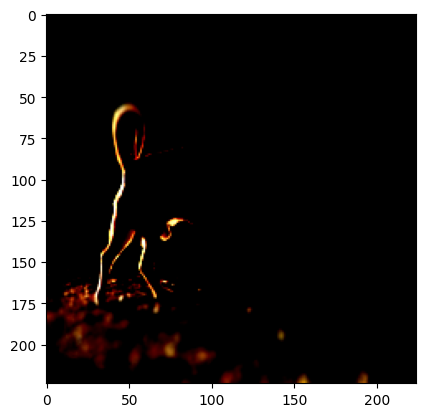

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_05458.jpg


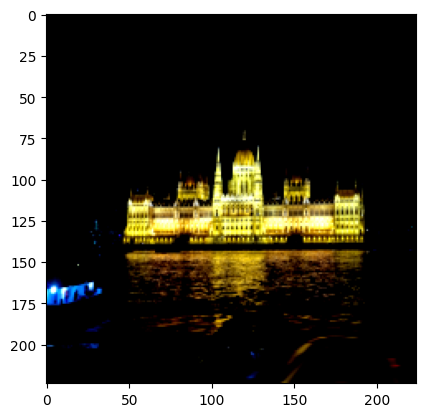

ラベル: Car
画像パス: /content/dark_images/Car/2015_02456.jpg


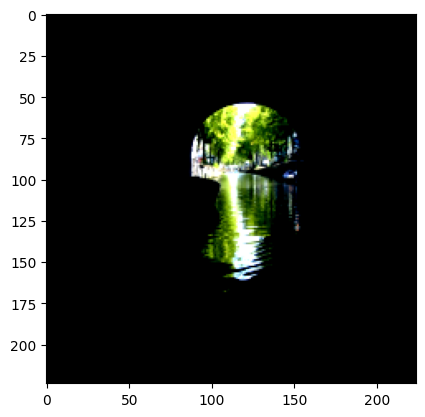

ラベル: Boat
画像パス: /content/dark_images/Boat/2015_01278.jpg


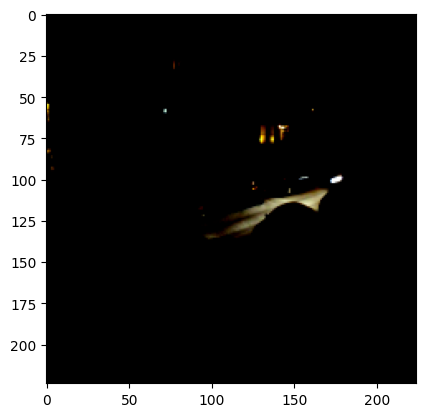

ラベル: Car
画像パス: /content/dark_images/Car/2015_02799.jpg
テストデータのサンプル:


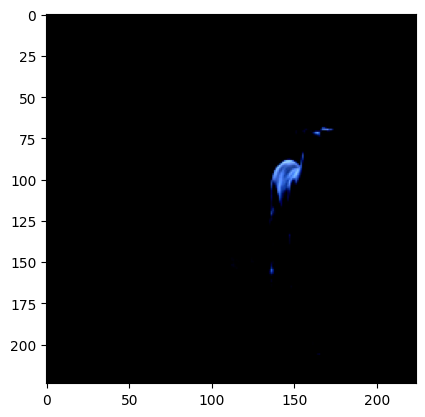

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_05399.jpg


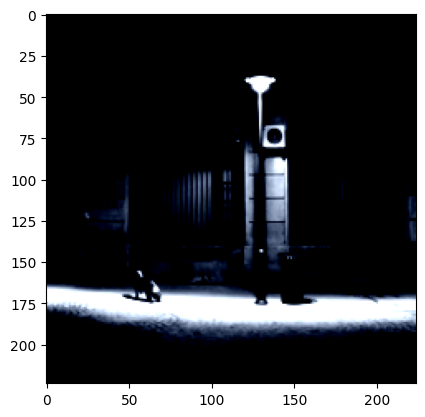

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_05160.jpg


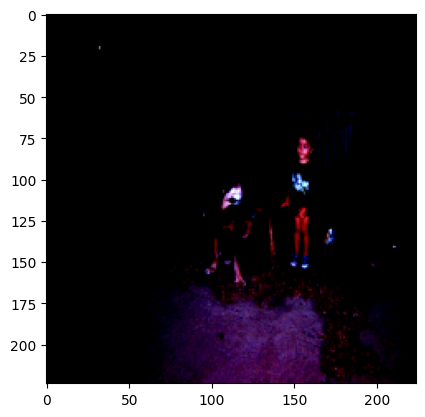

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_04973.jpg


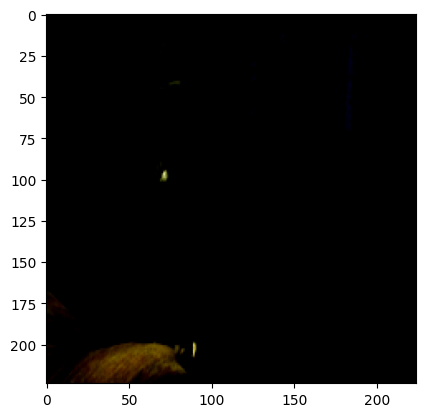

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_05354.jpg


In [15]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# データセットのパス
dataset_path = "/content/dark_images"

# カテゴリのマッピング
categories = {
    'Dog': 0,
    'Cat': 1,
    'Boat': 2,
    'Car': 3
}

# クラスラベルのリスト
class_names = list(categories.keys())

# 画像データを標準化する際の平均と分散、およびバッチサイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 8

# 前処理の設定
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# カスタムデータセットクラスの定義
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.paths = []

        for category in categories.keys():
            category_path = os.path.join(root_dir, category)
            label = categories[category]
            for root, _, files in os.walk(category_path):
                for file in files:
                    if file.endswith(('png', 'jpg', 'jpeg')):
                        img_path = os.path.join(root, file)
                        self.images.append(img_path)
                        self.labels.append(label)
                        self.paths.append(img_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

# データセットの作成
train_dataset_dark = CustomDataset(root_dir=dataset_path, transform=data_transform)
test_dataset_dark = CustomDataset(root_dir=dataset_path, transform=data_transform)

# データローダの作成
train_loader_dark = DataLoader(train_dataset_dark, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_dark = DataLoader(test_dataset_dark, batch_size=batch_size, shuffle=False, num_workers=2)

# 画像を表示する関数
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 各クラスのサンプルを表示する関数
def show_samples(loader, class_names, num_samples=4):
    dataiter = iter(loader)
    images, labels, paths = next(dataiter)

    # バッチから指定した数のサンプルを表示
    for i in range(num_samples):
        imshow(images[i])
        print(f'ラベル: {class_names[labels[i].item()]}')
        print(f'画像パス: {paths[i]}')

# 学習データのサンプルを表示
print("学習データのサンプル:")
show_samples(train_loader_dark, class_names, num_samples=4)

# テストデータのサンプルを表示
print("テストデータのサンプル:")
show_samples(test_loader_dark, class_names, num_samples=4)


# 前処理時点の仮説
- 暗闇画像はCifar10に比べて、ピクセルの値が0付近に多く集積する
- これを仮に”暗闇ノイズ”と呼ぶ。
- 暗闇ノイズにより、通常条件の画像に比べて情報の抜け落ちが発生するはずである。

→上記より、Cifar10に対して適切な前処理を行い、暗闇ノイズを与えたデータセットにすることで精度が向上するのではないか

# 分布の可視化結果
- 各チャネルについて140以上の値の情報はすべて抜け落ちている
- 60~140の明度の帯域でも、通常画像に比べて大きく抜け落ちている

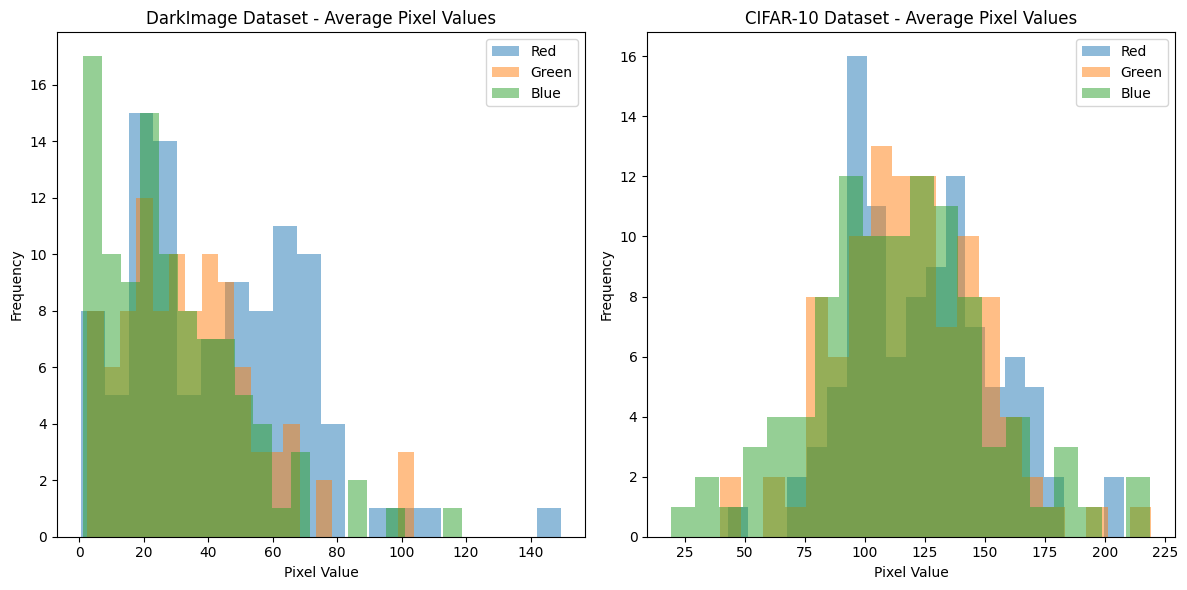

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

# DarkImageデータセットの平均値分布
def analyze_dark_images(image_files, num_samples=100):
    means = []
    for _ in range(num_samples):
      img_path = random.choice(image_files)
      img = Image.open(img_path).convert("RGB")
      img_array = np.array(img)
      means.append(np.mean(img_array, axis=(0, 1)))
    means = np.array(means)
    return means

# CIFAR-10データセットの平均値分布
def analyze_cifar10(trainset10, num_samples=100):
    means = []
    indices = random.sample(range(len(trainset10)), num_samples)
    for i in indices:
        img, _ = trainset10[i]
        img_array = np.transpose(img.numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_array = (img_array * 255).astype(np.uint8)
        means.append(np.mean(img_array, axis=(0, 1)))
    means = np.array(means)
    return means

# 解析結果の表示
def plot_distributions(dark_means, cifar_means):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(dark_means[:, 0], alpha=0.5, label="Red", bins=20)
    plt.hist(dark_means[:, 1], alpha=0.5, label="Green", bins=20)
    plt.hist(dark_means[:, 2], alpha=0.5, label="Blue", bins=20)
    plt.title('DarkImage Dataset - Average Pixel Values')
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(cifar_means[:, 0], alpha=0.5, label="Red", bins=20)
    plt.hist(cifar_means[:, 1], alpha=0.5, label="Green", bins=20)
    plt.hist(cifar_means[:, 2], alpha=0.5, label="Blue", bins=20)
    plt.title('CIFAR-10 Dataset - Average Pixel Values')
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# データセットのパスを定義
dataset_path = "/content/dark_images"
image_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg')):
            image_files.append(os.path.join(root, file))

# DarkImageデータセットの分析
dark_means = analyze_dark_images(image_files)

# CIFAR-10データセットの分析
cifar_means = analyze_cifar10(trainset10)

# 結果の表示
plot_distributions(dark_means, cifar_means)

## モデル群の定義

今回は計算の高速化と精度の向上を目的にResNet50をベースに講義で使用したWidebottleneckと同様のものを使用する。

In [8]:
class WideBottleneck(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        stride=1,
        downsample=False
    ):
        super(WideBottleneck, self).__init__()

        hidden_dim = output_dim * 2

        self.conv1 = nn.Conv2d(
            input_dim, hidden_dim,
            kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(
            hidden_dim, hidden_dim,
            kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        self.conv3 = nn.Conv2d(
            hidden_dim, output_dim * 4,
            kernel_size=1, stride=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(output_dim * 4)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    input_dim, output_dim * 4,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(output_dim * 4)
            )
        else:
            self.downsample = None

    def forward(self, x):
        shortcut = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            shortcut = self.downsample(shortcut)

        x += shortcut
        x = self.relu(x)

        return x

In [9]:
# torchvision から学習済み WideResNet50 を呼び出し
model_wide_resnet50 = wide_resnet50_2(pretrained=True)

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True),
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50.layer2 = nn.Sequential(
    WideBottleneck(256, 128,downsample=True, stride=2),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50.layer3 = nn.Sequential(
    WideBottleneck(512, 256,downsample=True, stride=2),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50.layer4 = nn.Sequential(
    WideBottleneck(1024, 512,downsample=True, stride=2),
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)

# WideResNet50 のアーキテクチャの表示
model_wide_resnet50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): WideBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [10]:
state_dict = torch.hub.load_state_dict_from_url("https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth", progress=True)
model_wide_resnet50.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

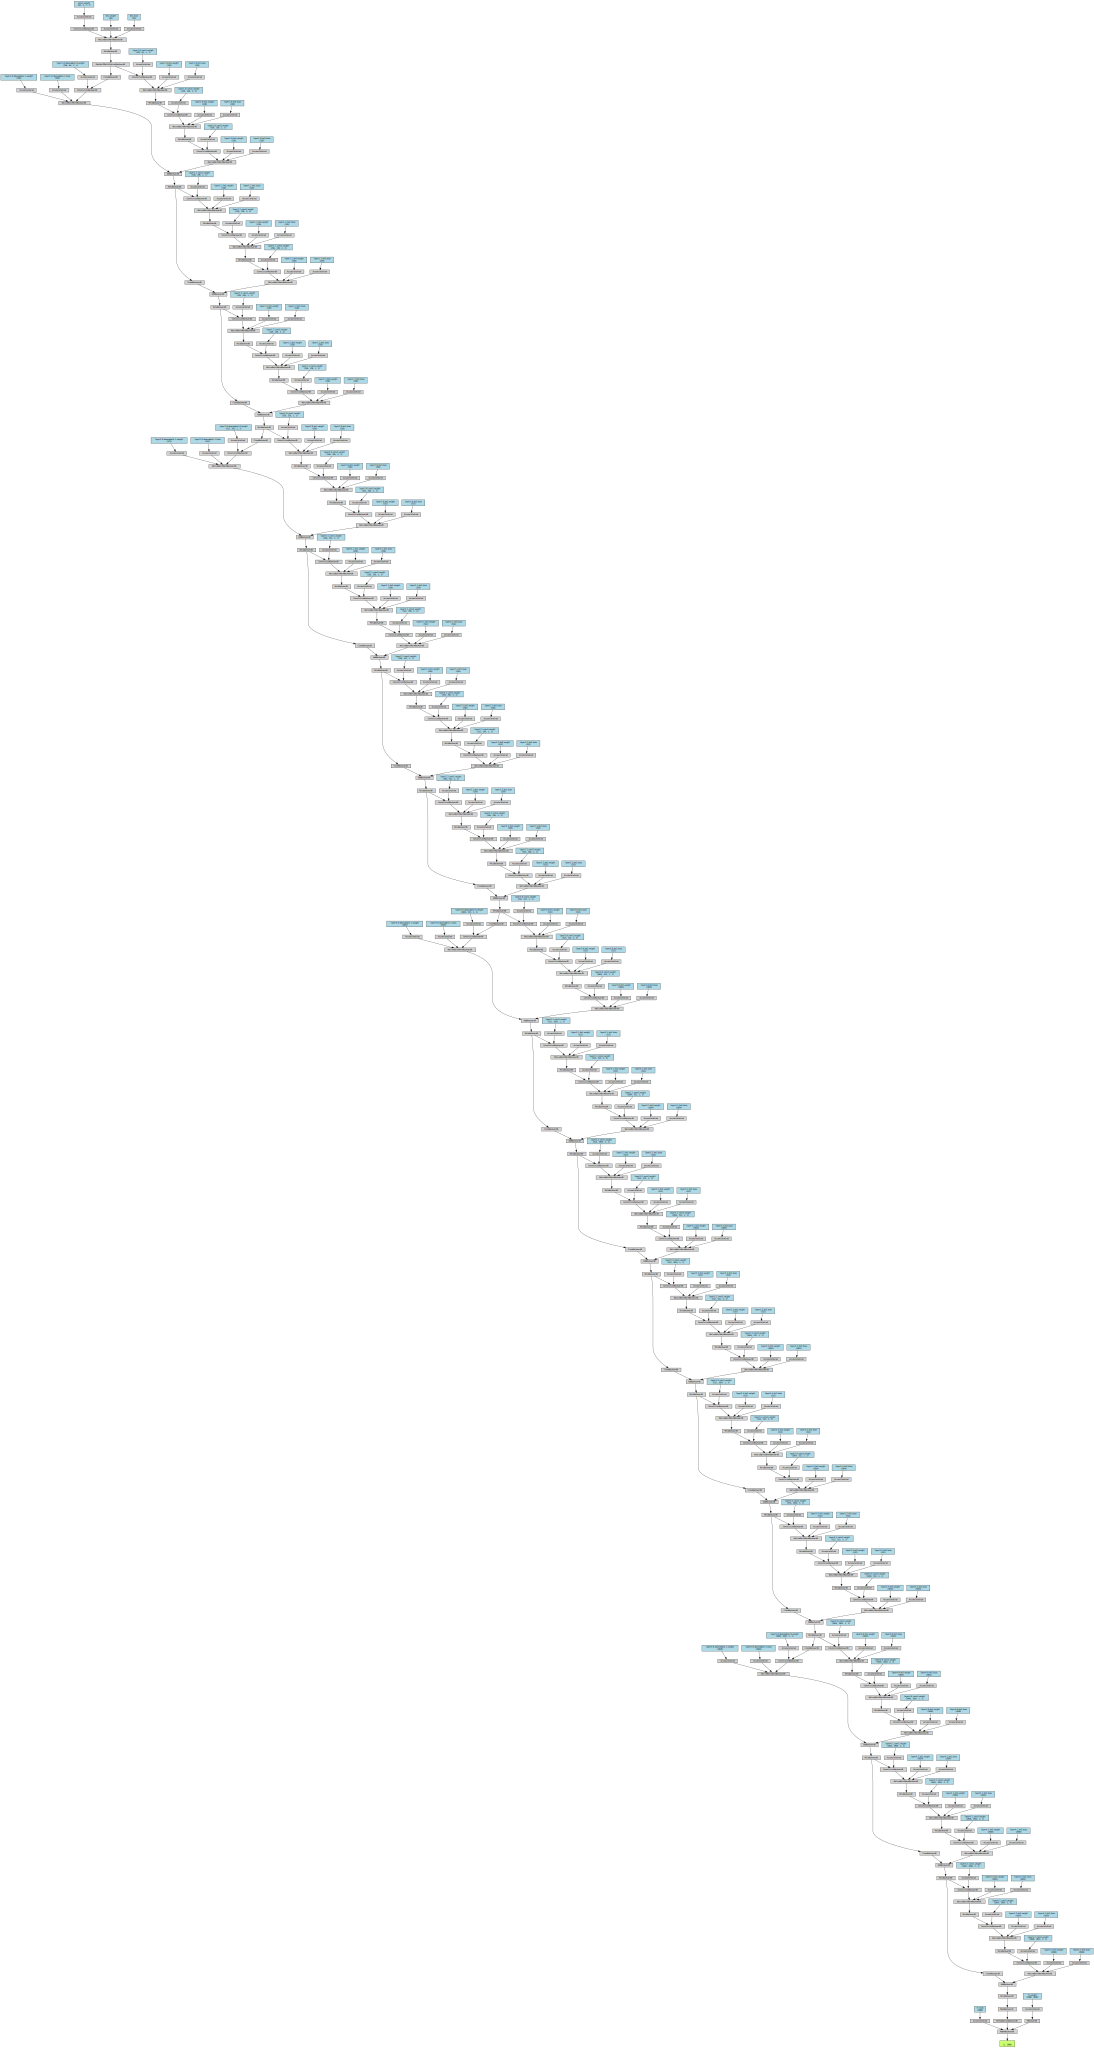

In [ ]:
import torch
!pip install torchviz
from torchviz import make_dot
# 大規模なイメージになってしまうがモデルのアーキテクチャを可視化する
dummy_input = torch.randn(1, 3, 224, 224)
dot = make_dot(model_wide_resnet50(dummy_input), params=dict(model_wide_resnet50.named_parameters()))

dot

In [11]:
feat_dim = model_wide_resnet50.fc.in_features
model_wide_resnet50.fc = nn.Linear(feat_dim, 4) #4クラス分類タスクなので出力層を調整
print(model_wide_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): WideBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

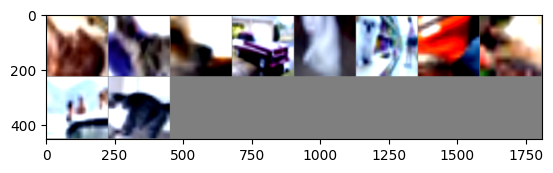

dog cat dog car cat dog ship cat ship cat


In [12]:

import matplotlib.pyplot as plt
import torchvision

dataiter = iter(trainloader10)
images10, labels10 = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images10))
print(' '.join(f'{classes[labels10[j]]}' for j in range(len(labels10))))


学習の開始

In [17]:
import matplotlib.pyplot as plt

# optimizer #学習済みモデルに対して、標準的なデータセットの学習なのでハイパパラメータはそのままで一度実行する。
optimizer = torch.optim.SGD(model_wide_resnet50.fc.parameters(), lr=0.002, momentum=0.8)

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(5):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader10): #Cifar10
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader10): #Cifar10
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# # 精度の遷移をプロット
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, 8), train_accuracies, label='Train Accuracy')
# plt.plot(range(1, 8), test_accuracies, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.title('Training and Test Accuracy Over Epochs')
# plt.legend()
# plt.show()

# ハイパーパラメータによる精度の変化
# lr=0.001 momentum=0.9→（Epoch1で77.90％→Epoch7で79.40％）
# lr=0.002 momentum=0.8→(Epoch1で73.7%→Epoch7で84.17%)
# lr=0.005 momentum0.9→（56.90%→76.33%）

Epoch: 1


  0%|          | 0/400 [00:00<?, ?it/s]

Train Accuracy: 57.55%


  0%|          | 0/400 [00:00<?, ?it/s]

Test Accuracy: 78.33%
Epoch: 2


  0%|          | 0/400 [00:00<?, ?it/s]

Train Accuracy: 65.25%


  0%|          | 0/400 [00:00<?, ?it/s]

Test Accuracy: 82.00%
Epoch: 3


  0%|          | 0/400 [00:00<?, ?it/s]

Train Accuracy: 66.55%


  0%|          | 0/400 [00:00<?, ?it/s]

Test Accuracy: 80.55%
Epoch: 4


  0%|          | 0/400 [00:00<?, ?it/s]

Train Accuracy: 68.83%


  0%|          | 0/400 [00:00<?, ?it/s]

Test Accuracy: 83.42%
Epoch: 5


  0%|          | 0/400 [00:00<?, ?it/s]

Train Accuracy: 68.60%


  0%|          | 0/400 [00:00<?, ?it/s]

Test Accuracy: 82.45%


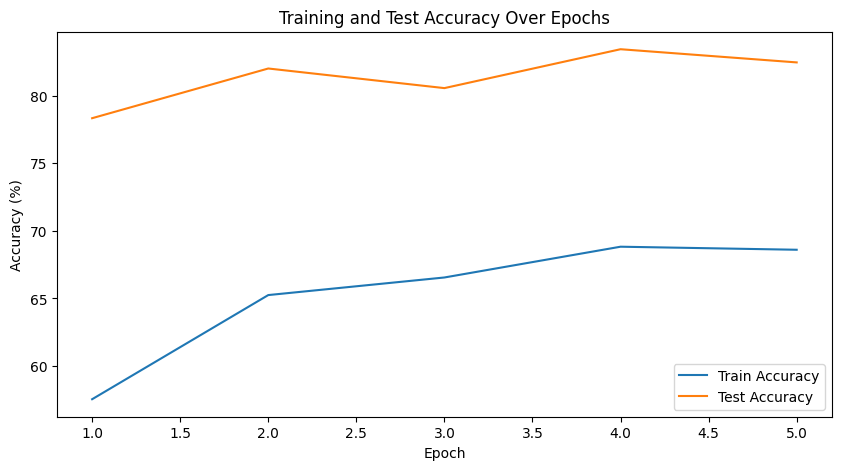

In [18]:
# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

学習結果は不十分ではあるが、、

## DarkImagesデータセットをCifar10による学習結果で予測する


100%|██████████| 328/328 [00:15<00:00, 20.53it/s]
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning

全体の精度: 17.14394807178312%
クラス 0 の精度: 5.049088359046284%
クラス 1 の精度: 1.680672268907563%
クラス 2 の精度: 10.668789808917197%
クラス 3 の精度: 59.219858156028366%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/li

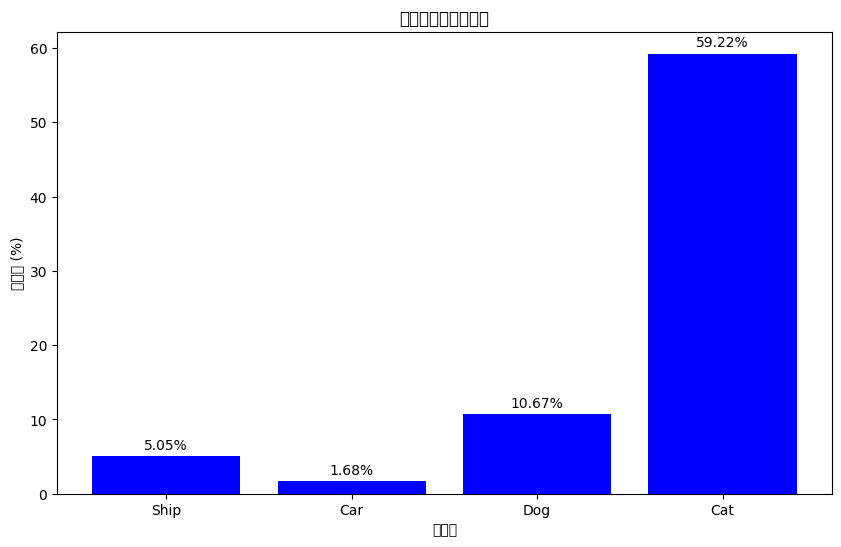

In [20]:
import torch.nn as nn

import matplotlib.pyplot as plt
# import numpy as np
from tqdm import tqdm



# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの評価モードへの変更
model_wide_resnet50.eval()

# 正解数と全体数の初期化
total = 0
correct = 0

# 各クラスの正解数と全体数の初期化
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

# テストデータの評価
with torch.no_grad():
    for inputs, labels,_ in tqdm(test_loader_dark):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        # 各クラスの正解数と全体数を更新
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        # 全体の正解数と全体数を更新
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 全体精度の表示
print(f"全体の精度: {100 * correct / total}%")

# 各クラスの精度の表示
for i in range(num_classes):
    print(f"クラス {i} の精度: {100 * class_correct[i] / class_total[i]}%")

# 各クラスの精度をグラフで表示
fig, ax = plt.subplots(figsize=(10, 6))
classes = ['Ship', 'Car', 'Dog', 'Cat']  # クラスのラベル

# 棒グラフの描画
bar = ax.bar(classes, [100 * class_correct[i] / class_total[i] for i in range(num_classes)], color='b')

# グラフの設定
ax.set_xlabel('クラス')
ax.set_ylabel('正解率 (%)')
ax.set_title('各クラスの識別精度')

# 棒グラフに数値を表示
for rect in bar:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


分類の結果
* 暗闇などの条件下では通常画像によるモデルでは、ほとんど予測できない
* 犬など、特に特徴がわかりやすい画像では、暗闇でも予測が可能であるようだ
* 船はそもそもCifar10のクラスと異なっている可能性もある。

念のためもう一度、ハイパーパラメータを調整して学習を試みる。

## 同じ条件を異なるハイパーパラメータで学習を試みる




 lr=0.003, momentum=0.9のケース

Epoch: 1


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]


Train Accuracy: 52.55%


100%|██████████| 400/400 [00:13<00:00, 29.96it/s]


Test Accuracy: 68.80%
Epoch: 2


100%|██████████| 400/400 [00:41<00:00,  9.54it/s]


Train Accuracy: 65.53%


100%|██████████| 400/400 [00:13<00:00, 29.77it/s]


Test Accuracy: 76.47%
Epoch: 3


100%|██████████| 400/400 [00:42<00:00,  9.48it/s]


Train Accuracy: 68.85%


100%|██████████| 400/400 [00:13<00:00, 29.64it/s]


Test Accuracy: 83.83%
Epoch: 4


100%|██████████| 400/400 [00:42<00:00,  9.46it/s]


Train Accuracy: 73.75%


100%|██████████| 400/400 [00:13<00:00, 29.42it/s]


Test Accuracy: 83.15%
Epoch: 5


100%|██████████| 400/400 [00:42<00:00,  9.44it/s]


Train Accuracy: 74.42%


100%|██████████| 400/400 [00:13<00:00, 29.47it/s]


Test Accuracy: 82.28%
Epoch: 6


100%|██████████| 400/400 [00:42<00:00,  9.44it/s]


Train Accuracy: 77.28%


100%|██████████| 400/400 [00:13<00:00, 29.32it/s]


Test Accuracy: 87.12%
Epoch: 7


100%|██████████| 400/400 [00:42<00:00,  9.37it/s]


Train Accuracy: 77.70%


100%|██████████| 400/400 [00:13<00:00, 29.36it/s]


Test Accuracy: 89.00%


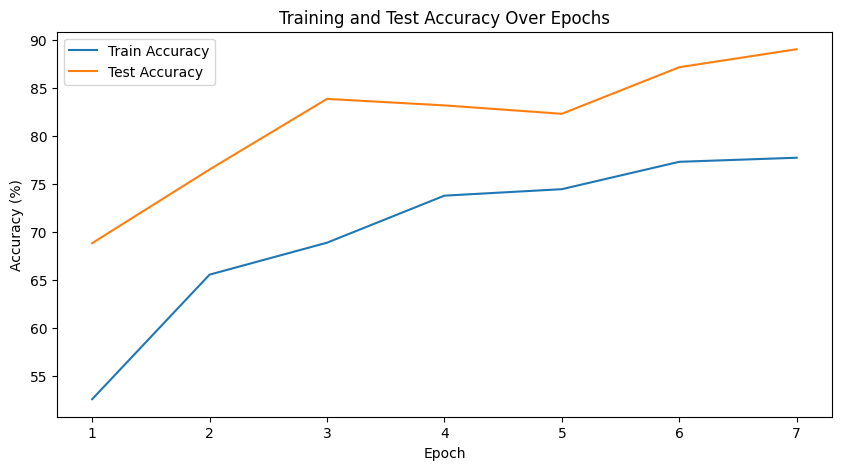

In [21]:
# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50.parameters(), lr=0.003, momentum=0.9)

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(7):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader10): # cifar 10
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader10): # Cifar10
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 8), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()



In [25]:
save_path = "/content/drive/MyDrive/AI/E資格/プロダクト演習/InitialAttemptCifar10"
os.makedirs(save_path, exist_ok=True)
file_name = "wide_resnet50_2_cifar10.pth"

torch.save(model_wide_resnet50.state_dict(), os.path.join(save_path, file_name))

print(f"Model saved to {os.path.join(save_path, file_name)}")

Model saved to /content/drive/MyDrive/AI/E資格/プロダクト演習/InitialAttemptCifar10/wide_resnet50_2_cifar10.pth


100%|██████████| 328/328 [00:14<00:00, 23.09it/s]
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning

全体の精度: 18.365788468881252%
クラス 0 の精度: 10.93969144460028%
クラス 1 の精度: 13.305322128851541%
クラス 2 の精度: 0.7961783439490446%
クラス 3 の精度: 53.723404255319146%


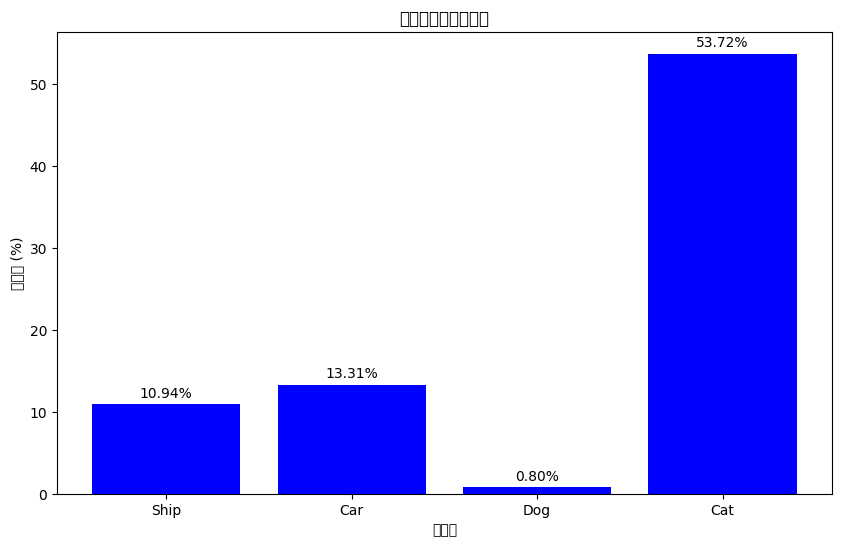

In [24]:
# データセットを含むtrain_loaderの設定
# train_loader = torch.utils.data.DataLoader(
#     trainset, batch_size=batch_size, shuffle=True, num_workers=2
# )

# データセットを含むtest_loaderの設定
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの評価モードへの変更
model_wide_resnet50.eval()

# 正解数と全体数の初期化
total = 0
correct = 0

# 各クラスの正解数と全体数の初期化
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

# テストデータの評価
with torch.no_grad():
    for inputs, labels,_ in tqdm(test_loader_dark): #dark images
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        # 各クラスの正解数と全体数を更新
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        # 全体の正解数と全体数を更新
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 全体精度の表示
print(f"全体の精度: {100 * correct / total}%")

# 各クラスの精度の表示
for i in range(num_classes):
    print(f"クラス {i} の精度: {100 * class_correct[i] / class_total[i]}%")

# 各クラスの精度をグラフで表示
fig, ax = plt.subplots(figsize=(10, 6))
classes = ['Ship', 'Car', 'Dog', 'Cat']  # クラスのラベル

# 棒グラフの描画
bar = ax.bar(classes, [100 * class_correct[i] / class_total[i] for i in range(num_classes)], color='b')

# グラフの設定
ax.set_xlabel('クラス')
ax.set_ylabel('正解率 (%)')
ax.set_title('各クラスの識別精度')

# 棒グラフに数値を表示
for rect in bar:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


### # 所感
性質の大きく異なるデータセット同士ではほとんど分類問題が解けないことが分かった。
したがって、二つのデータセットを混合したりなどはせず、以降はDarkImagesのみを用いて分類を行う。

###  # Cifar10による学習と分類
* 今度はDogなどのクラスで精度が低く、CatやShipで20％以上の精度が出た。
* 暗闇ノイズにより、予測が不安定になっていることがわかる。
* 犬などのわかりやすいクラスでも、関係なくノイズの影響が大きい。
* 通常のモデルでは、条件の異なる画像では不安定になることが確認できた。

# DarkImagesを用いたResNet50（ファインチューニング）

> 引用を追加


性質の大きく異なるものであるため学習率は0.003程度と通常よりも大きく設定。
学習済みのWideResnetを呼び出し、4クラス分類可能にし、
DarkImagesデータセットを学習させる。

※結論：過学習の発生

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1


100%|██████████| 328/328 [00:28<00:00, 11.58it/s]


Train Accuracy: 31.12%


100%|██████████| 328/328 [00:14<00:00, 23.10it/s]


Test Accuracy: 39.02%
Epoch: 2


100%|██████████| 328/328 [00:28<00:00, 11.41it/s]


Train Accuracy: 37.99%


100%|██████████| 328/328 [00:14<00:00, 22.74it/s]


Test Accuracy: 44.25%
Epoch: 3


100%|██████████| 328/328 [00:29<00:00, 11.30it/s]


Train Accuracy: 42.23%


100%|██████████| 328/328 [00:14<00:00, 23.22it/s]


Test Accuracy: 36.92%
Epoch: 4


100%|██████████| 328/328 [00:29<00:00, 11.11it/s]


Train Accuracy: 44.10%


100%|██████████| 328/328 [00:14<00:00, 22.69it/s]


Test Accuracy: 38.34%
Epoch: 5


100%|██████████| 328/328 [00:29<00:00, 10.96it/s]


Train Accuracy: 43.07%


100%|██████████| 328/328 [00:14<00:00, 23.18it/s]


Test Accuracy: 38.53%
Epoch: 6


100%|██████████| 328/328 [00:29<00:00, 11.08it/s]


Train Accuracy: 45.21%


100%|██████████| 328/328 [00:14<00:00, 23.26it/s]


Test Accuracy: 45.48%
Epoch: 7


100%|██████████| 328/328 [00:29<00:00, 11.01it/s]


Train Accuracy: 49.06%


100%|██████████| 328/328 [00:14<00:00, 22.98it/s]


Test Accuracy: 52.20%


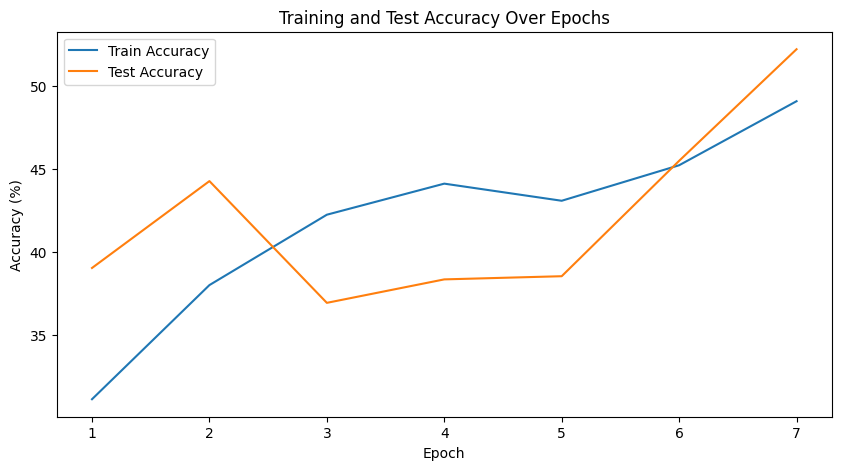

Model saved to /content/drive/MyDrive/AI/E資格/プロダクト演習/Cifar10AndDarkImagesMixedModels/wide_resnet50_finetuned_DarkImages_1st_attempt.pth


In [28]:
# torchvision より実装済みの WideResNet50 を呼び出し
model_wide_resnet50_pretrained_and_darkonly = wide_resnet50_2(pretrained=True)

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50_pretrained_and_darkonly.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True),
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50_pretrained_and_darkonly.layer2 = nn.Sequential(
    WideBottleneck(256, 128,downsample=True, stride=2),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50_pretrained_and_darkonly.layer3 = nn.Sequential(
    WideBottleneck(512, 256,downsample=True, stride=2),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50_pretrained_and_darkonly.layer4 = nn.Sequential(
    WideBottleneck(1024, 512,downsample=True, stride=2),
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)


# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_pretrained_and_darkonly.parameters(), lr=0.004, momentum=0.9)

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_pretrained_and_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(7):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_pretrained_and_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels,_ in tqdm(train_loader_dark):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_pretrained_and_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_pretrained_and_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels,_ in tqdm(test_loader_dark):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_pretrained_and_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 8), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()



file_name = "/content/drive/MyDrive/AI/E資格/プロダクト演習/Cifar10AndDarkImagesMixedModels/wide_resnet50_finetuned_DarkImages_1st_attempt.pth"
torch.save(model_wide_resnet50_pretrained_and_darkonly.state_dict(), os.path.join(save_path, file_name))
print(f"Model saved to {os.path.join(save_path, file_name)}")

順調に学習している様子である。

まだ50％に満たない程度の精度であるため、もう少し反復回数を増やすと向上する可能性がある。

Epoch: 1


100%|██████████| 328/328 [00:29<00:00, 11.11it/s]


Train Accuracy: 52.96%


100%|██████████| 328/328 [00:14<00:00, 23.38it/s]


Test Accuracy: 52.58%
Epoch: 2


100%|██████████| 328/328 [00:29<00:00, 11.14it/s]


Train Accuracy: 54.94%


100%|██████████| 328/328 [00:14<00:00, 23.17it/s]


Test Accuracy: 55.40%
Epoch: 3


100%|██████████| 328/328 [00:29<00:00, 11.07it/s]


Train Accuracy: 55.52%


100%|██████████| 328/328 [00:14<00:00, 22.83it/s]


Test Accuracy: 57.69%
Epoch: 4


100%|██████████| 328/328 [00:29<00:00, 11.14it/s]


Train Accuracy: 56.55%


100%|██████████| 328/328 [00:14<00:00, 22.99it/s]


Test Accuracy: 60.79%
Epoch: 5


100%|██████████| 328/328 [00:29<00:00, 11.16it/s]


Train Accuracy: 57.01%


100%|██████████| 328/328 [00:14<00:00, 23.05it/s]


Test Accuracy: 59.18%
Epoch: 6


100%|██████████| 328/328 [00:29<00:00, 11.21it/s]


Train Accuracy: 58.95%


100%|██████████| 328/328 [00:14<00:00, 23.18it/s]


Test Accuracy: 59.53%
Epoch: 7


100%|██████████| 328/328 [00:29<00:00, 11.12it/s]


Train Accuracy: 58.99%


100%|██████████| 328/328 [00:14<00:00, 23.21it/s]


Test Accuracy: 63.92%
Epoch: 8


100%|██████████| 328/328 [00:29<00:00, 11.20it/s]


Train Accuracy: 60.33%


100%|██████████| 328/328 [00:14<00:00, 23.26it/s]


Test Accuracy: 66.82%
Epoch: 9


100%|██████████| 328/328 [00:29<00:00, 11.10it/s]


Train Accuracy: 63.00%


100%|██████████| 328/328 [00:14<00:00, 23.33it/s]


Test Accuracy: 67.81%
Epoch: 10


100%|██████████| 328/328 [00:29<00:00, 11.19it/s]


Train Accuracy: 63.96%


100%|██████████| 328/328 [00:14<00:00, 23.41it/s]


Test Accuracy: 70.83%
Epoch: 11


100%|██████████| 328/328 [00:29<00:00, 11.06it/s]


Train Accuracy: 66.17%


100%|██████████| 328/328 [00:14<00:00, 23.34it/s]


Test Accuracy: 70.48%
Epoch: 12


100%|██████████| 328/328 [00:29<00:00, 11.04it/s]


Train Accuracy: 66.63%


100%|██████████| 328/328 [00:14<00:00, 22.94it/s]


Test Accuracy: 66.82%


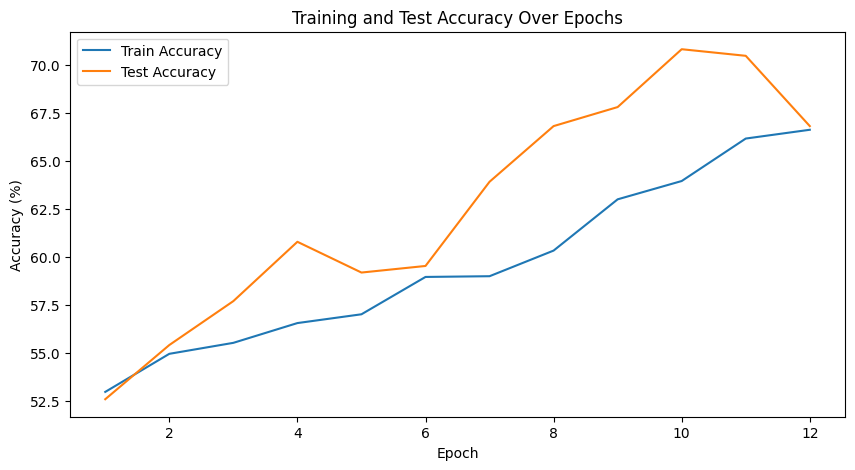

In [29]:
# 反復回数を増やし

# DarkImagesのTrainloaderとTestloader

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_pretrained_and_darkonly.parameters(), lr=0.003, momentum=0.8)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_pretrained_and_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

# エポックを12にする
for epoch in range(12):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_pretrained_and_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels,_ in tqdm(train_loader_dark):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_pretrained_and_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_pretrained_and_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels,_ in tqdm(test_loader_dark):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_pretrained_and_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 13), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()



In [32]:
model_path = "/content/drive/MyDrive/AI/E資格/プロダクト演習/Cifar10AndDarkImagesMixedModels/wide_resnet50_finetuned_DarkImages_2nd_attempt.pth"
torch.save(model_wide_resnet50_pretrained_and_darkonly.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/AI/E資格/プロダクト演習/Cifar10AndDarkImagesMixedModels/wide_resnet50_finetuned_DarkImages_2nd_attempt.pth


### 過学習が起きている
* 暗闇画像をもとに学習しても、ノイズの影響で適切に学習できていない。
* 特徴量の検出ができていない可能性がある。
* 学習済みモデルのファインチューニングであるため、過去の学習の影響を受けている可能性がある。

まずは、以下のようにファインチューニングでない構築で検証する。

#DarkImagesImagesのみで構築するファインチューニングでないパターン
ここで、学習データの増加と精度改善のため、データ拡張と交差学習を取り入れる



In [42]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from tqdm import tqdm

# カテゴリの設定
categories = {
    'Dog': 0,
    'Cat': 1,
    'Boat': 2,
    'Car': 3
}

# データセットの拡張済みパス
augmented_dataset_path = "/content/augmented_dark_images"

# 平均と標準偏差 (標準化用)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# データ拡張の設定
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

augmentations = [
    transforms.RandomHorizontalFlip(p=1.0),  # 左右反転
    transforms.RandomRotation(50),          # 回転 (-30度から30度)
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),  # 拡大縮小
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # 明るさ・コントラスト調整
    transforms.RandomGrayscale(p = 1.0), # グレースケール
    transforms.RandomPerspective(p = 1.0) # 射影
]

# カスタムデータセットクラス
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.paths = []

        for category in categories.keys():
            category_path = os.path.join(root_dir, category)
            label = categories[category]
            for root, _, files in os.walk(category_path):
                for file in files:
                    if file.endswith(('png', 'jpg', 'jpeg')):
                        img_path = os.path.join(root, file)
                        self.images.append(img_path)
                        self.labels.append(label)
                        self.paths.append(img_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

# 基本のデータセット
base_dataset = CustomDataset(root_dir=augmented_dataset_path, transform=basic_transform)

# 拡張データセットの作成 (基本データセット + 拡張データ)
augmented_datasets = [base_dataset]  # 元データをまず追加
for aug in augmentations:
    augmented_datasets.append(CustomDataset(root_dir=augmented_dataset_path, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        aug,
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])))

# すべてのデータセットを結合
final_dataset_dark_enhanced = ConcatDataset(augmented_datasets)
print(f"Final Dataset size after augmentation: {len(final_dataset_dark_enhanced)}")

# サンプル画像を表示する関数
def show_samples(dataset, num_samples=5):
    for i in range(num_samples):
        r = random.randint(0, len(dataset) - 1)
        image, label, path = dataset[r]
        plt.imshow(image.permute(1, 2, 0).numpy() * std + mean)  # 標準化を逆変換
        plt.title(f"Label: {list(categories.keys())[label]} \n Path: {path}")
        plt.axis('off')
        plt.show()


# 訓練 + 検証データ (95%) とテストデータ (5%) に分割
train_val_indices, test_indices = train_test_split(
    list(range(len(final_dataset_dark_enhanced))), test_size=0.05, random_state=42
)

# テストデータのサブセット
test_subset = Subset(final_dataset_dark_enhanced, test_indices)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False, num_workers=2)

# 残りのデータ (訓練 + 検証用)
train_val_subset = Subset(final_dataset_dark_enhanced, train_val_indices)

# K-Fold 設定
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 交差検証のセットアップ
for fold, (train_indices, val_indices) in enumerate(kf.split(train_val_subset)):
    print(f"\n=== Fold {fold + 1}/{k_folds} ===")
    train_subset = Subset(train_val_subset, train_indices)
    val_subset = Subset(train_val_subset, val_indices)

    train_loader = DataLoader(train_subset, batch_size=10, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=10, shuffle=False, num_workers=2)


Final Dataset size after augmentation: 2730

=== Fold 1/5 ===

=== Fold 2/5 ===

=== Fold 3/5 ===

=== Fold 4/5 ===

=== Fold 5/5 ===


Sample images from the augmented dataset:


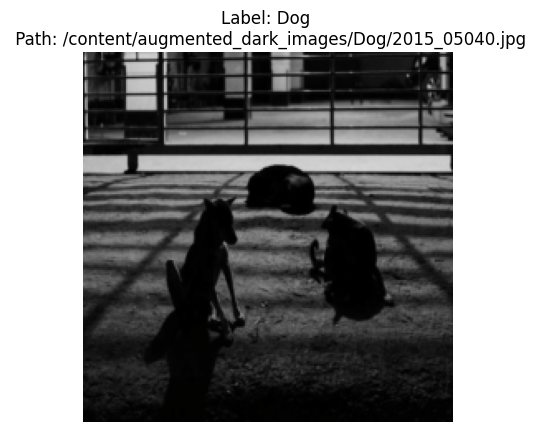

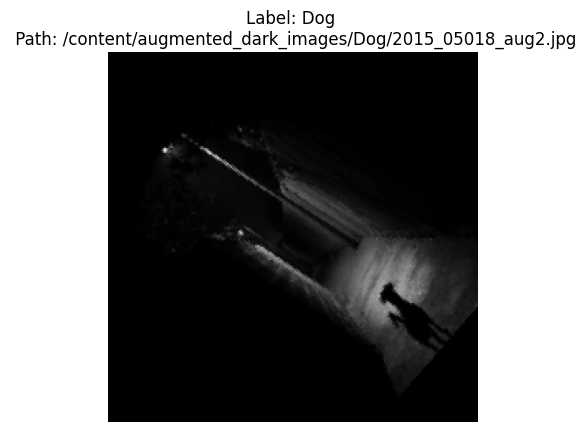

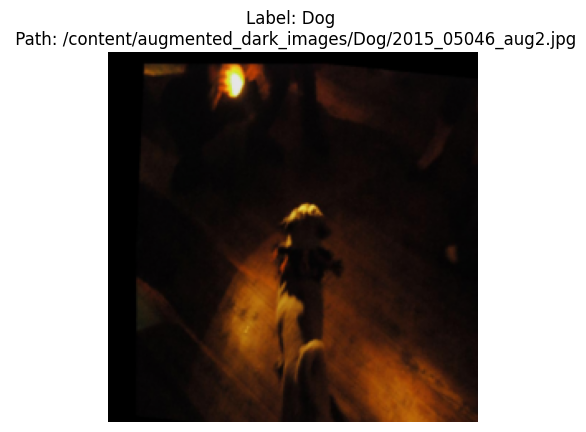

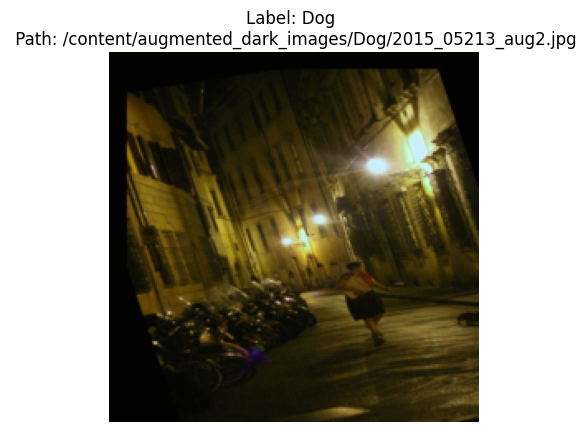

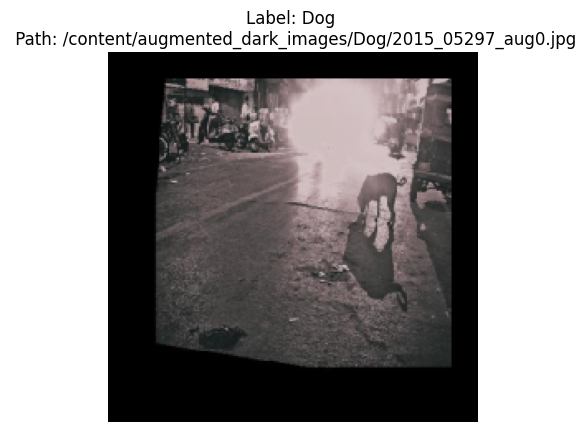

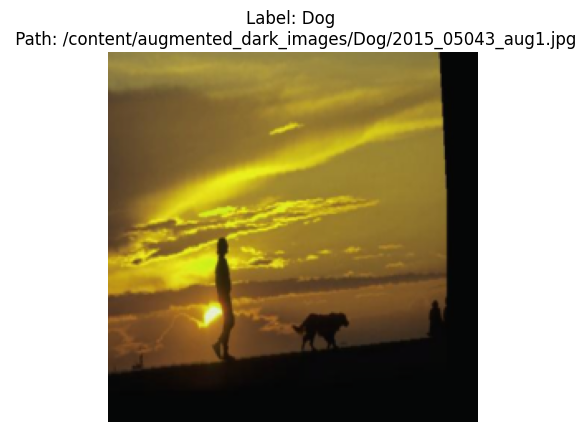

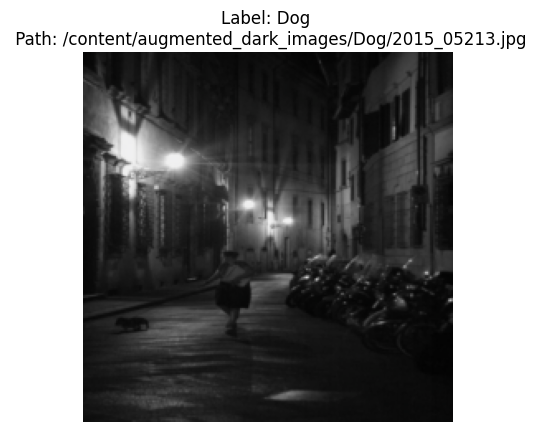

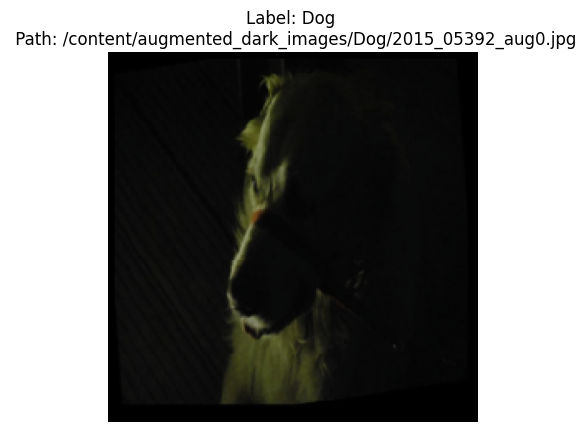

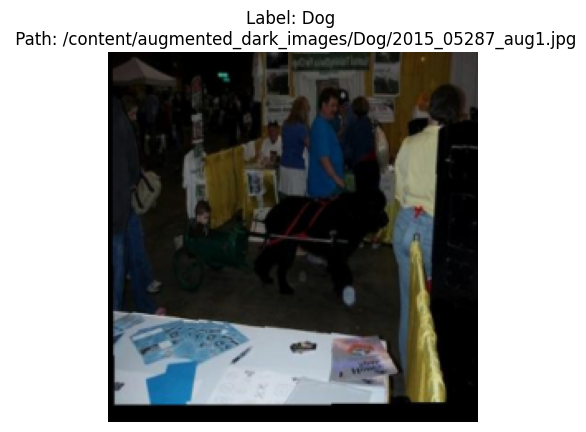

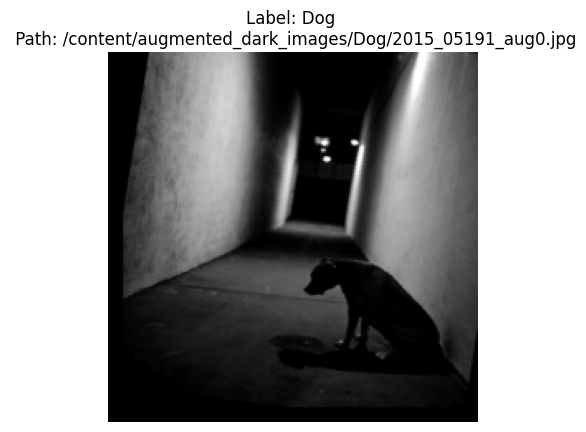

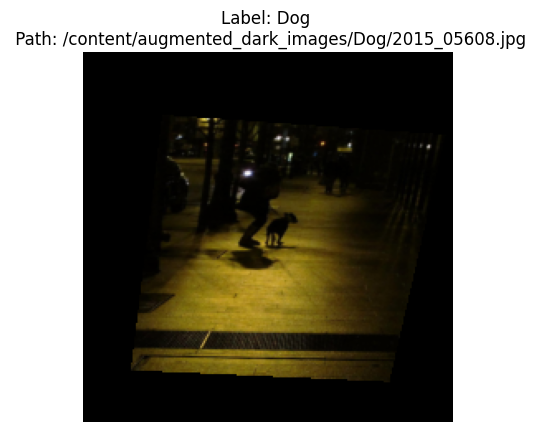

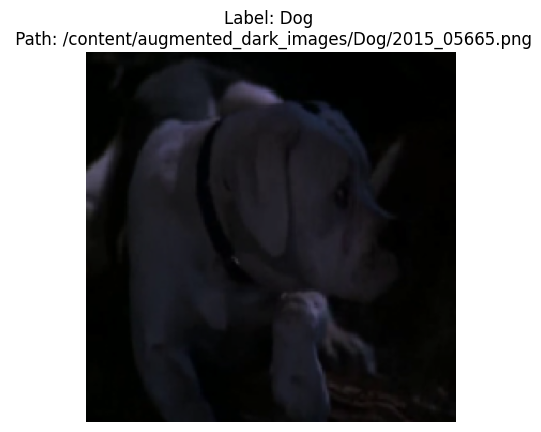

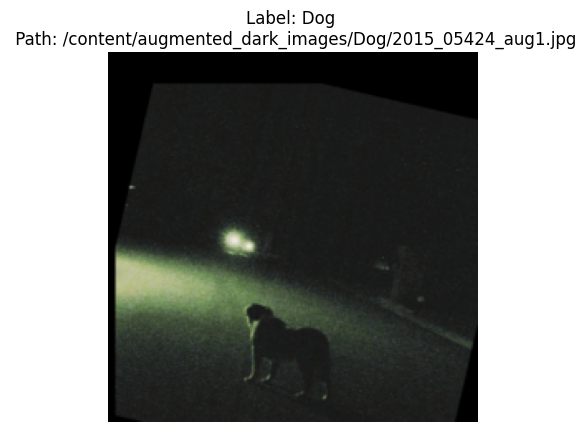

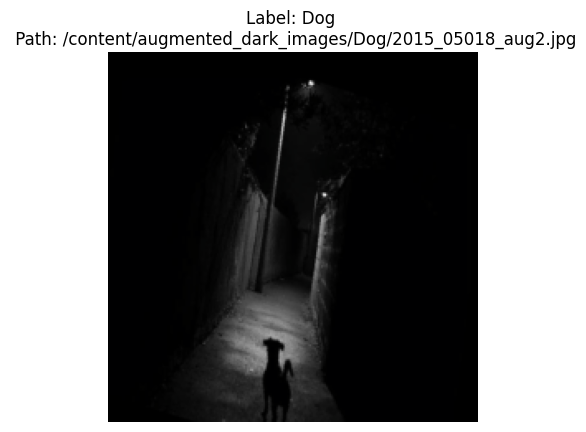

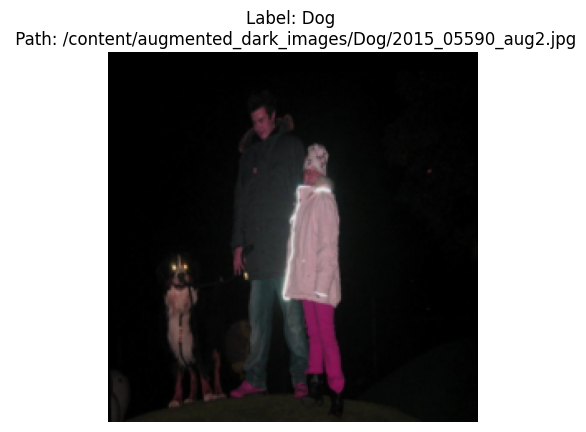

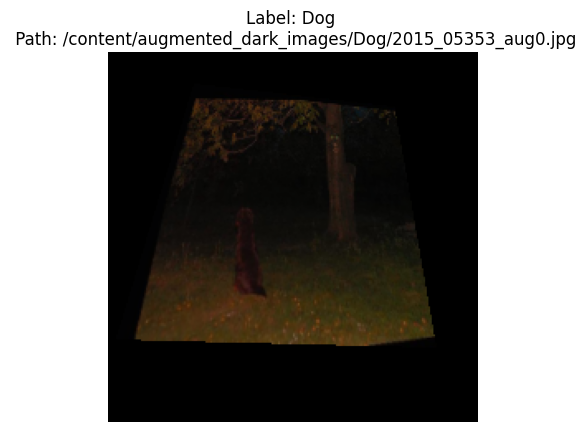

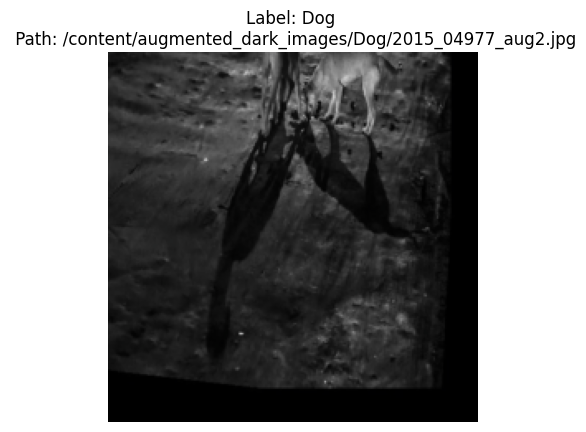

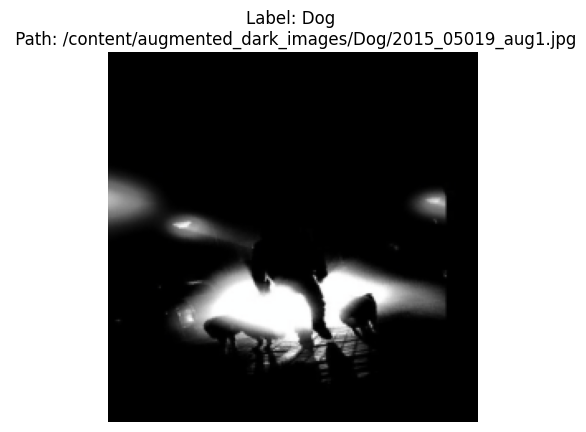

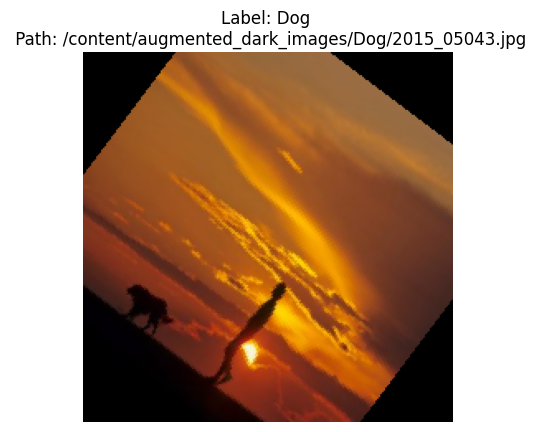

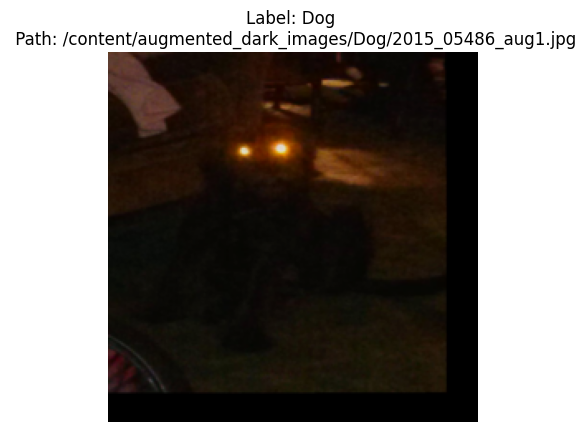

In [43]:
# サンプルを表示
print("Sample images from the augmented dataset:")
show_samples(final_dataset_dark_enhanced, num_samples=20)


In [ ]:

# モデルの定義 (WideResNet50)
model_wide_resnet50_darkonly = wide_resnet50_2(pretrained=False)
model_wide_resnet50_darkonly.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True),
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50_darkonly.layer2 = nn.Sequential(
    WideBottleneck(256, 128, downsample=True, stride=2),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50_darkonly.layer3 = nn.Sequential(
    WideBottleneck(512, 256, downsample=True, stride=2),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50_darkonly.layer4 = nn.Sequential(
    WideBottleneck(1024, 512, downsample=True, stride=2),
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)
model_wide_resnet50_darkonly.to(device)

# 最適化と損失関数
optimizer = torch.optim.SGD(model_wide_resnet50_darkonly.parameters(), lr=0.002, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

# K-Fold設定
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 交差検証
fold_train_accuracies = []
fold_val_accuracies = []

for fold, (train_indices, val_indices) in enumerate(kf.split(train_val_subset)):
    print(f"\n=== Fold {fold + 1}/{k_folds} ===")

    # 訓練データと検証データの分割
    train_subset = Subset(train_val_subset, train_indices)
    val_subset = Subset(train_val_subset, val_indices)

    train_loader = DataLoader(train_subset, batch_size=10, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=10, shuffle=False, num_workers=2)

    # 精度リスト
    train_accuracies = []
    val_accuracies = []

    for epoch in range(7):  # エポック数は7
        print(f"Epoch {epoch + 1}/7")

        # 訓練フェーズ
        model_wide_resnet50_darkonly.train()
        train_correct = 0
        train_total = 0
        for inputs, labels, _ in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # 順伝播
            outputs = model_wide_resnet50_darkonly(inputs)
            loss = loss_fn(outputs, labels)

            # 逆伝播とパラメータ更新
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 精度計算
            _, preds = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_accuracy)
        print(f"Train Accuracy: {train_accuracy:.2f}%")

        # 検証フェーズ
        model_wide_resnet50_darkonly.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels, _ in tqdm(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model_wide_resnet50_darkonly(inputs)
                _, preds = torch.max(outputs, 1)

                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

# テストデータで最終評価
model_wide_resnet50_darkonly.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels, _ in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_wide_resnet50_darkonly(inputs)
        _, preds = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"\nTest Accuracy on unseen data: {test_accuracy:.2f}%")


=== Fold 1/5 ===
Epoch 1/7


100%|██████████| 208/208 [00:23<00:00,  8.78it/s]


Train Accuracy: 99.52%


100%|██████████| 52/52 [00:03<00:00, 16.26it/s]


Validation Accuracy: 100.00%
Epoch 2/7


100%|██████████| 208/208 [00:21<00:00,  9.52it/s]


Train Accuracy: 100.00%


100%|██████████| 52/52 [00:02<00:00, 22.00it/s]


Validation Accuracy: 100.00%
Epoch 3/7


100%|██████████| 208/208 [00:22<00:00,  9.45it/s]


Train Accuracy: 100.00%


100%|██████████| 52/52 [00:02<00:00, 22.13it/s]


Validation Accuracy: 100.00%
Epoch 4/7


100%|██████████| 208/208 [00:22<00:00,  9.44it/s]


Train Accuracy: 100.00%


100%|██████████| 52/52 [00:02<00:00, 22.51it/s]


Validation Accuracy: 100.00%
Epoch 5/7


100%|██████████| 208/208 [00:22<00:00,  9.41it/s]


Train Accuracy: 100.00%


100%|██████████| 52/52 [00:02<00:00, 22.61it/s]


Validation Accuracy: 100.00%
Epoch 6/7


 38%|███▊      | 79/208 [00:08<00:13,  9.39it/s]

In [ ]:
# （旧）学習の開始
model_wide_resnet50_darkonly = wide_resnet50_2(pretrained=False) ## 学習済みでないモデルの呼び出し

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50_darkonly.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True),
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50_darkonly.layer2 = nn.Sequential(
    WideBottleneck(256, 128,downsample=True, stride=2),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50_darkonly.layer3 = nn.Sequential(
    WideBottleneck(512, 256,downsample=True, stride=2),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50_darkonly.layer4 = nn.Sequential(
    WideBottleneck(1024, 512,downsample=True, stride=2),
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)

# WideResNet50 のアーキテクチャの表示
print(model_wide_resnet50_darkonly)

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_darkonly.parameters(), lr=0.002, momentum=0.9)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(7):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 8), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()




安定的に学習が進んでいる。
まだ50％であるため、学習回数を増加する。

In [ ]:
# 学習結果が安定的なので、ハイパーパラメータはそのままで反復回数を増加する

# torchvision より実装済みの WideResNet50 を呼び出し

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_darkonly.parameters(), lr=0.002, momentum=0.9)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(12):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 13), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()




通常通り実装したResNetでは暗闇画像で学習しても今回の分類タスクが解けないことが分かった。

暗闇画像に対してなんらかの処理を施して実装することでよい結果が得られるのではないか。

ここでは、エッジ検出とエッジ強調フィルタを用いて特徴量を強調する。

# データセット全体にエッジ検出＆強調フィルタを行う

先の議論から、データセット全体にフィルターを行うことにする。
今回は通常のエッジ検出と強調を行うことで、暗闇ノイズを抑え、特徴量の強調を行う。


In [ ]:
import os
from PIL import Image, ImageFilter
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt

# データセットのパス
dataset_path = "/content/dark_images"

# カテゴリのマッピング
categories = {
    'Dog': 0,
    'Cat': 1,
    'Boat': 2,
    'Car': 3
}

# クラスラベルのリスト
class_names = list(categories.keys())

# 画像データを標準化する際の平均と分散、およびバッチサイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 8

# エッジ強調フィルターを施すためのカスタムTransformの定義
class EdgeEnhance:
    def __call__(self, image):
        edge_enhanced_image = image.filter(ImageFilter.EDGE_ENHANCE)
        return edge_enhanced_image

# 前処理の設定（エッジ強調フィルターを含む）
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    EdgeEnhance(),  # エッジ強調フィルターの適用
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# カスタムデータセットクラスの定義
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.paths = []

        for category in categories.keys():
            category_path = os.path.join(root_dir, category)
            label = categories[category]
            for root, _, files in os.walk(category_path):
                for file in files:
                    if file.endswith(('png', 'jpg', 'jpeg')):
                        img_path = os.path.join(root, file)
                        self.images.append(img_path)
                        self.labels.append(label)
                        self.paths.append(img_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# データセットの作成
dataset_edge = CustomDataset(root_dir=dataset_path, transform=data_transform)

# データセットの分割（40%を学習用、40%をテスト用、20%を最終検証用）
train_size = int(0.45 * len(dataset_edge))
test_size = int(0.45 * len(dataset_edge))
val_size = len(dataset_edge) - train_size - test_size
train_dataset, test_dataset, val_dataset = random_split(dataset_edge, [train_size, test_size, val_size])

# データローダの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# 画像を表示する関数
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 各クラスのサンプルを表示する関数
def show_samples(loader, class_names, num_samples=4):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # バッチから指定した数のサンプルを表示
    for i in range(num_samples):
        imshow(images[i])
        print(f'ラベル: {class_names[labels[i].item()]}')

# 学習データのサンプルを表示
print("学習データのサンプル:")
show_samples(train_loader, class_names, num_samples=4)

# テストデータのサンプルを表示
print("テストデータのサンプル:")
show_samples(test_loader, class_names, num_samples=4)

# 検証データのサンプルを表示
print("検証データのサンプル:")
show_samples(val_loader, class_names, num_samples=4)


In [ ]:
model_wide_resnet50_darkonly_edgeenhanced = wide_resnet50_2(pretrained=False)

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50_darkonly_edgeenhanced.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True),
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50_darkonly_edgeenhanced.layer2 = nn.Sequential(
    WideBottleneck(256, 128,downsample=True, stride=2),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50_darkonly_edgeenhanced.layer3 = nn.Sequential(
    WideBottleneck(512, 256,downsample=True, stride=2),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50_darkonly_edgeenhanced.layer4 = nn.Sequential(
    WideBottleneck(1024, 512,downsample=True, stride=2),
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)

# WideResNet50 のアーキテクチャの表示
print(model_wide_resnet50_darkonly_edgeenhanced)

Epoch: 1


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 38.83%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 44.67%
Epoch: 2


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 45.21%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 48.22%
Epoch: 3


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 48.00%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 49.90%
Epoch: 4


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 49.37%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 52.54%
Epoch: 5


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 50.55%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 57.04%
Epoch: 6


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 52.20%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 52.23%
Epoch: 7


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 51.70%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 60.10%
Epoch: 8


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 55.14%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 54.98%
Epoch: 9


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 55.36%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 61.09%
Epoch: 10


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 57.92%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 61.44%
Epoch: 11


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 57.85%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 64.34%
Epoch: 12


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 62.39%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 66.02%


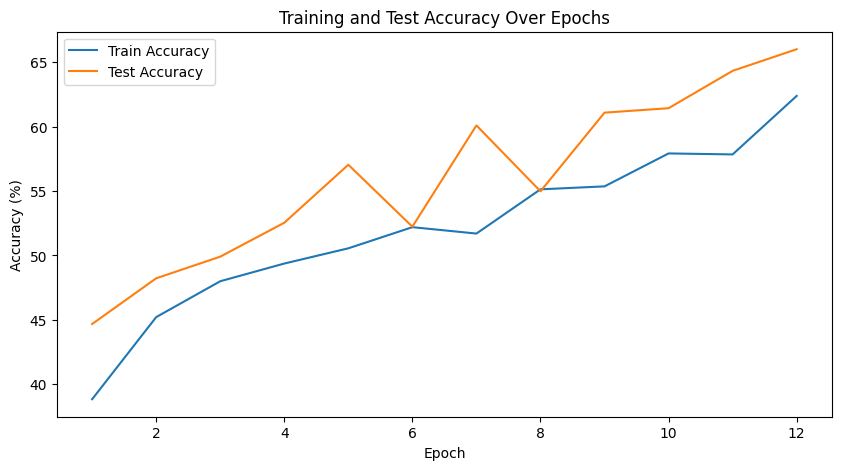

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset_edge, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(dataset_edge, batch_size=batch_size, shuffle=True, num_workers=2)

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_darkonly_edgeenhanced.parameters(), lr=0.003, momentum=0.8)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_darkonly_edgeenhanced.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(12):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_darkonly_edgeenhanced.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_darkonly_edgeenhanced.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 13), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()




学習回数を増加させて学習を進める。

Epoch: 1


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 64.83%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 69.30%
Epoch: 2


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 67.74%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 68.69%
Epoch: 3


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 69.61%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 77.05%
Epoch: 4


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 72.62%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 77.85%
Epoch: 5


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 73.31%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 76.75%
Epoch: 6


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 76.44%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 81.48%
Epoch: 7


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 78.62%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 88.77%
Epoch: 8


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 81.14%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 87.51%
Epoch: 9


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 84.19%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 83.35%
Epoch: 10


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 87.09%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 89.08%
Epoch: 11


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 87.25%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 89.00%
Epoch: 12


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 89.04%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 92.29%
Epoch: 13


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 90.42%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 92.86%
Epoch: 14


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 91.07%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 90.15%
Epoch: 15


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 93.36%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 97.86%
Epoch: 16


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 94.01%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 97.25%
Epoch: 17


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 95.57%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 94.43%
Epoch: 18


  0%|          | 0/328 [00:00<?, ?it/s]

Train Accuracy: 95.30%


  0%|          | 0/328 [00:00<?, ?it/s]

Test Accuracy: 94.04%


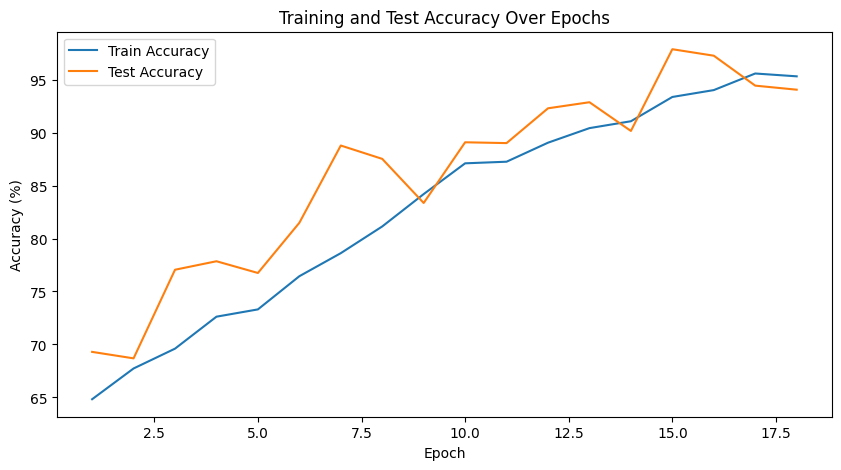

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset_edge, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(dataset_edge, batch_size=batch_size, shuffle=True, num_workers=2)

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_darkonly_edgeenhanced.parameters(), lr=0.002, momentum=0.8)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_darkonly_edgeenhanced.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(18):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_darkonly_edgeenhanced.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_darkonly_edgeenhanced.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 19), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 19), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()




検証用にとっておいたモデルにとって未知のデータである、全体の20％を格納したValLoaderを用いて検証を行う

100%|██████████| 33/33 [00:02<00:00, 11.19it/s]
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: 

全体の精度: 94.67680608365019%
クラス 0 の精度: 92.95774647887323%
クラス 1 の精度: 90.78947368421052%
クラス 2 の精度: 96.875%
クラス 3 の精度: 100.0%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/li

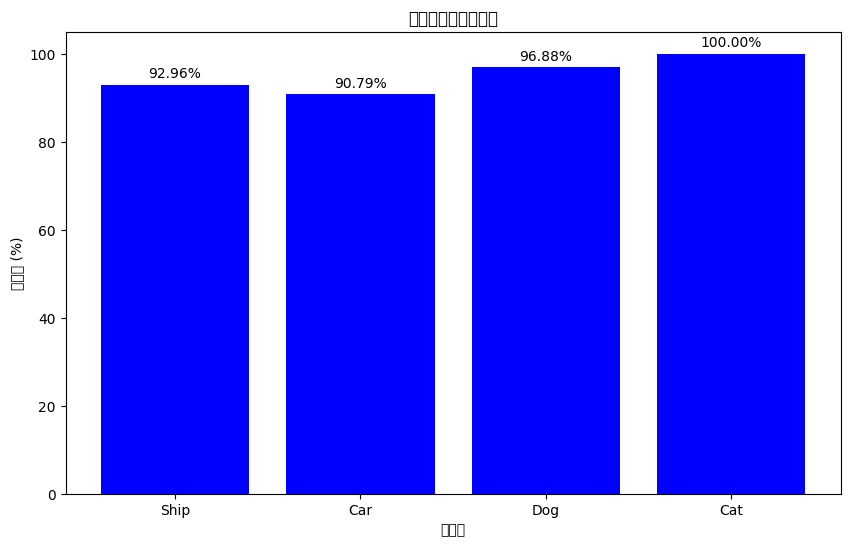

In [ ]:
import torch.nn as nn

import matplotlib.pyplot as plt
# import numpy as np
from tqdm import tqdm

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの評価モードへの変更
model_wide_resnet50_darkonly_edgeenhanced.eval()

# 正解数と全体数の初期化
total = 0
correct = 0

# 各クラスの正解数と全体数の初期化
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

# テストデータの評価
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        # 各クラスの正解数と全体数を更新
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        # 全体の正解数と全体数を更新
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 全体精度の表示
print(f"全体の精度: {100 * correct / total}%")

# 各クラスの精度の表示
for i in range(num_classes):
    print(f"クラス {i} の精度: {100 * class_correct[i] / class_total[i]}%")

# 各クラスの精度をグラフで表示
fig, ax = plt.subplots(figsize=(10, 6))
classes = ['Ship', 'Car', 'Dog', 'Cat']  # クラスのラベル

# 棒グラフの描画
bar = ax.bar(classes, [100 * class_correct[i] / class_total[i] for i in range(num_classes)], color='b')

# グラフの設定
ax.set_xlabel('クラス')
ax.set_ylabel('正解率 (%)')
ax.set_title('各クラスの識別精度')

# 棒グラフに数値を表示
for rect in bar:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


### 学習が不足していると考えられるため、追加で6エポック分学習回数を追加する。


Epoch: 1


100%|██████████| 328/328 [00:29<00:00, 11.09it/s]


Train Accuracy: 94.92%


100%|██████████| 328/328 [00:15<00:00, 21.03it/s]


Test Accuracy: 97.44%
Epoch: 2


100%|██████████| 328/328 [00:29<00:00, 11.13it/s]


Train Accuracy: 96.41%


100%|██████████| 328/328 [00:15<00:00, 21.13it/s]


Test Accuracy: 95.49%
Epoch: 3


100%|██████████| 328/328 [00:29<00:00, 11.05it/s]


Train Accuracy: 95.76%


100%|██████████| 328/328 [00:15<00:00, 21.29it/s]


Test Accuracy: 90.38%
Epoch: 4


100%|██████████| 328/328 [00:29<00:00, 11.13it/s]


Train Accuracy: 95.76%


100%|██████████| 328/328 [00:15<00:00, 21.40it/s]


Test Accuracy: 95.99%
Epoch: 5


100%|██████████| 328/328 [00:29<00:00, 11.13it/s]


Train Accuracy: 97.10%


100%|██████████| 328/328 [00:15<00:00, 20.87it/s]


Test Accuracy: 98.43%
Epoch: 6


100%|██████████| 328/328 [00:29<00:00, 11.06it/s]


Train Accuracy: 97.29%


100%|██████████| 328/328 [00:15<00:00, 20.97it/s]


Test Accuracy: 95.80%


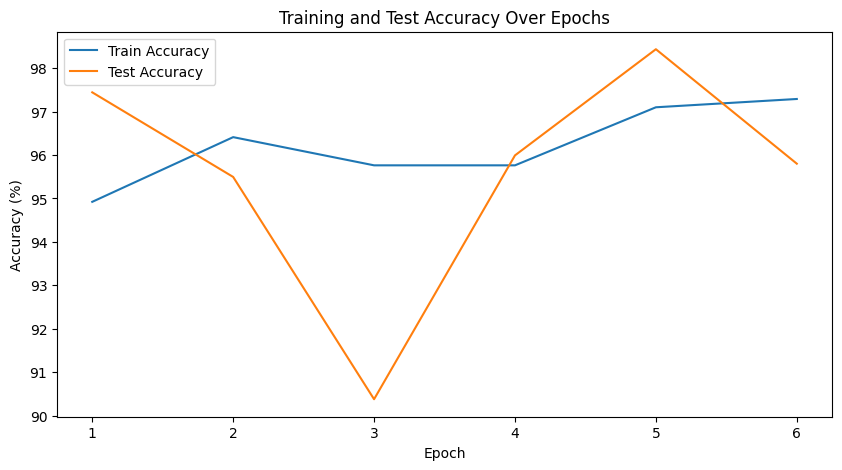

In [ ]:
model_wide_resnet50_darkonly_edgeenhanced.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(6):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_darkonly_edgeenhanced.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_darkonly_edgeenhanced.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 7), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 7), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()




In [ ]:
import torch.nn as nn

import matplotlib.pyplot as plt
# import numpy as np
from tqdm import tqdm

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの評価モードへの変更
model_wide_resnet50_darkonly_edgeenhanced.eval()

# 正解数と全体数の初期化
total = 0
correct = 0

# 各クラスの正解数と全体数の初期化
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

# テストデータの評価
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        # 各クラスの正解数と全体数を更新
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        # 全体の正解数と全体数を更新
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 全体精度の表示
print(f"全体の精度: {100 * correct / total}%")

# 各クラスの精度の表示
for i in range(num_classes):
    print(f"クラス {i} の精度: {100 * class_correct[i] / class_total[i]}%")

# 各クラスの精度をグラフで表示
fig, ax = plt.subplots(figsize=(10, 6))
classes = ['Ship', 'Car', 'Dog', 'Cat']  # クラスのラベル

# 棒グラフの描画
bar = ax.bar(classes, [100 * class_correct[i] / class_total[i] for i in range(num_classes)], color='b')

# グラフの設定
ax.set_xlabel('クラス')
ax.set_ylabel('正解率 (%)')
ax.set_title('各クラスの識別精度')

# 棒グラフに数値を表示
for rect in bar:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


NameError: name 'torch' is not defined

100%|██████████| 33/33 [00:01<00:00, 16.51it/s]


全体の精度: 96.95817490494296%
クラス 0 の精度: 100.0%
クラス 1 の精度: 93.42105263157895%
クラス 2 の精度: 98.4375%
クラス 3 の精度: 96.15384615384616%


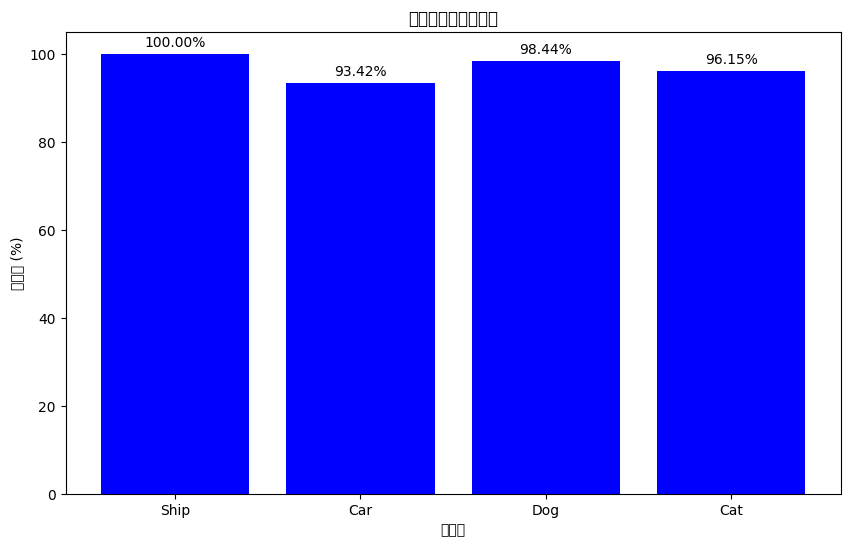

In [ ]:
import torch.nn as nn

import matplotlib.pyplot as plt
# import numpy as np
from tqdm import tqdm

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの評価モードへの変更
model_wide_resnet50_darkonly_edgeenhanced.eval()

# 正解数と全体数の初期化
total = 0
correct = 0

# 各クラスの正解数と全体数の初期化
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

# テストデータの評価
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        # 各クラスの正解数と全体数を更新
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        # 全体の正解数と全体数を更新
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 全体精度の表示
print(f"全体の精度: {100 * correct / total}%")

# 各クラスの精度の表示
for i in range(num_classes):
    print(f"クラス {i} の精度: {100 * class_correct[i] / class_total[i]}%")

# 各クラスの精度をグラフで表示
fig, ax = plt.subplots(figsize=(10, 6))
classes = ['Ship', 'Car', 'Dog', 'Cat']  # クラスのラベル

# 棒グラフの描画
bar = ax.bar(classes, [100 * class_correct[i] / class_total[i] for i in range(num_classes)], color='b')

# グラフの設定
ax.set_xlabel('クラス')
ax.set_ylabel('正解率 (%)')
ax.set_title('各クラスの識別精度')

# 棒グラフに数値を表示
for rect in bar:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


In [ ]:
# 誤分類した画像を保存するディレクトリ
save_dir = "/content/drive/MyDrive/AI/E資格/プロダクト演習"
os.makedirs(save_dir, exist_ok=True)

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの評価モード
model_wide_resnet50_darkonly_edgeenhanced.eval()

# 誤分類例を保存するためのリスト
wrong_images = []
wrong_labels = []
correct_labels = []


# ValLoaderの件数カウント
val_count = 0

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        val_count += labels.size(0)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
              img = inputs[i].cpu()
              wrong_images.append(img)
              wrong_labels.append(predicted[i].item())
              correct_labels.append(labels[i].item())
              # 画像を保存 (Driveに保存)
              img_path = os.path.join(save_dir, f"wrong_classified_{len(wrong_images)}.png")
              torchvision.utils.save_image(img, img_path)


print(f"ValLoaderの件数: {val_count}")

# 誤分類例を表示（最大3つ）
num_wrong_samples = min(3, len(wrong_images))
for i in range(num_wrong_samples):
  imshow(wrong_images[i])
  print(f"予測：{class_names[wrong_labels[i]]} 正解：{class_names[correct_labels[i]]}")


# 正解例を表示（最大3つ）
correct_images = []
correct_labels_displayed = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_wide_resnet50_darkonly_edgeenhanced(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
          if predicted[i] == labels[i] and len(correct_images) < 3:
              img = inputs[i].cpu()
              correct_images.append(img)
              correct_labels_displayed.append(labels[i].item())

for i in range(len(correct_images)):
    imshow(correct_images[i])
    print(f"予測：{class_names[correct_labels_displayed[i]]} 正解：{class_names[correct_labels_displayed[i]]}")


NameError: name 'os' is not defined

## モデルがどこを見ているか、Chapter9の手法を用いて確認する
GradCam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 19.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 35.1 MB/s et

In [ ]:
wrong_image_1_path = "/content/drive/MyDrive/AI/E資格/プロダクト演習/wrong_classified_1.png"
wrong_image_2_path = "/content/drive/MyDrive/AI/E資格/プロダクト演習/wrong_classified_2.png"
wrong_image_3_path =
true_image_1_path =
true_image_2_path =
true_image_3_path =

# 結果
暗闇画像では、通常通りのモデル構築手法では過学習を起こしたり、そもそも精度が50％を超えないことが確認された。

この問題に対し、元画像に対してエッジ検出を行うことで、高い精度で物体検知とクラス分類が可能になった。しかも、モデルが未知のデータに対しての検証であるため、かなりよいモデルが得られたといえる。

今回は論文などで公表されているモデルに比べて非常にシンプルで、Resnet自体には大幅な改変を加えていない。フィルタの変更だけでクラス分類精度が大幅に向上した。

結論としてエッジ検出と強調が非常にシンプルかつ有効な手段であることが確認できた

## 検証の前提に存在する問題点
今回のデータセットでは、暗闇画像のデータ数が少なく、学習用のデータが少なかった。

これに対する解決策としては、暗闇のようなフィルターを用意し、

## クラス間の比較
犬と猫に対しては90%前後の精度、特に犬に関しては100%近い結果が得られた。
しかし、一回目の検証では、ボートと車のクラスに関しては70%程度の精度だった。

## 学習回数追加後
6回の追加を行った後の二回目の精度の検証では、犬猫クラスは変わらず高い精度のままCarクラスの精度が大幅に上昇させることに成功した。


# さらなる展開
論文等を見ると、DenseNetなど、条件の悪い画像専用のモデルがあった。
今回失敗したShipクラスに関してさらなる向上を目指す場合、以下のような方法があると考えられる。
* DenseNetなどのモデルの利用
* YOLOなど、異なるアーキテクチャをベースにしたモデルの構築

上記のような方法で、暗闇画像の分類精度を向上することができると考えられる。

### さらに暗い画像に対する処理
* Quanta Image Sensorのような手法もある。

https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123530477.pdf
